### 1. Import modules

In [13]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from functions.shap_forceplots import vacc_shap_force
import shap
from sklearn import tree

### 2. Import .pkl's

In [14]:
# Load data
X_zuigelingen_numericals = pd.read_pickle('4_Data/Pickles/X_zuigelingen_numericals.pkl')
X_zuigelingen_booleans = pd.read_pickle('4_Data/Pickles/X_zuigelingen_booleans.pkl')
y_zuigelingen = np.load('4_Data/Arrays/y_zuigelingen.npy')

# Merge data
X_zuigelingen = pd.concat([X_zuigelingen_numericals, X_zuigelingen_booleans], axis=1)

### 3. Supervised ML for explainability

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_zuigelingen, y_zuigelingen, test_size=0.3, random_state=42)

In [16]:
shap.initjs()

In [17]:
# Initialize the Random Forest Classifier
clf_rf = RandomForestClassifier(random_state=42)

# Train the classifier
clf_rf.fit(X_train, y_train)

# Make predictions
y_pred = clf_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.25      0.31        65
           1       0.18      0.06      0.09        69
           2       0.93      0.98      0.96      1482

    accuracy                           0.91      1616
   macro avg       0.51      0.43      0.45      1616
weighted avg       0.88      0.91      0.89      1616

Confusion Matrix:
[[  16    6   43]
 [   4    4   61]
 [  18   12 1452]]


In [18]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(clf_rf)
shap_values = explainer.shap_values(X_train)

In [19]:
vacc_shap_force(clf_rf, 306,
                 X_train, y_train,
                 explainer,
                 shap_values,
                 classes='all')

***************************************************
Ground Truth Label: 2 - Vaccinated

Model Prediction:  [2] - Vaccinated -- Correct!
***************************************************


Not Vaccinated (0)



Partially Vaccinated (1)



Vaccinated (2)


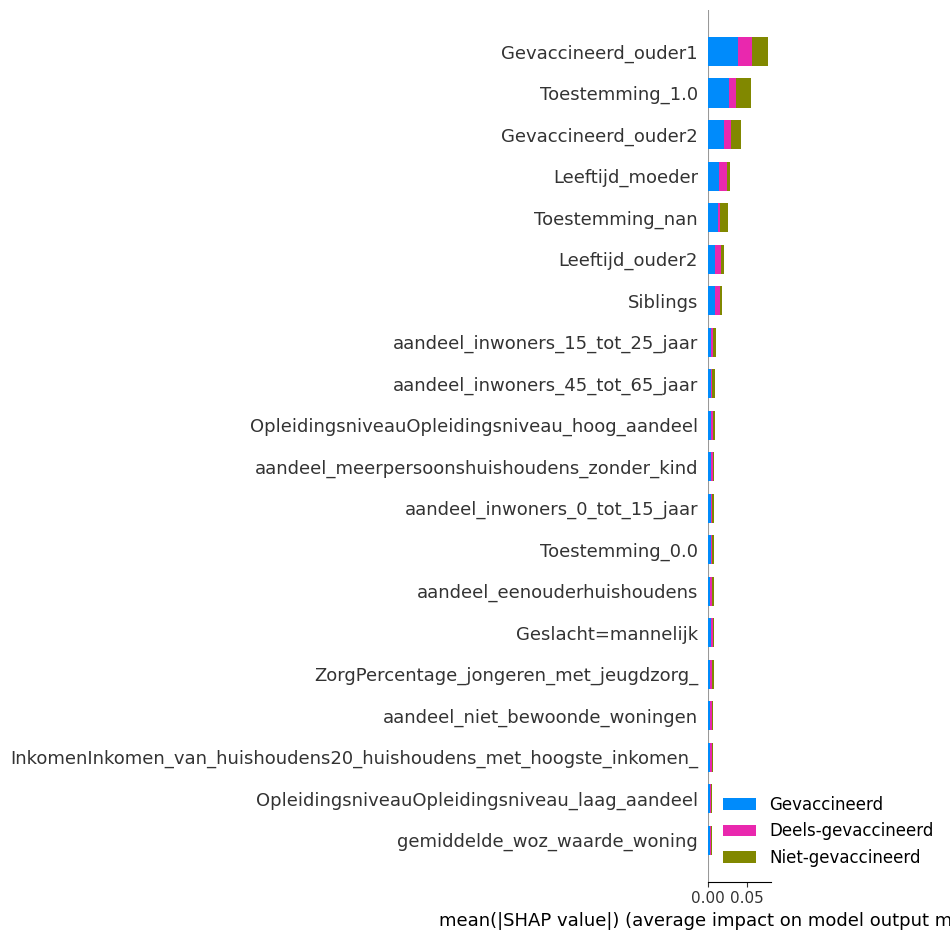

In [20]:
# Split the array into a list of arrays, one for each class
multi_shap_vals = [shap_values[:, :, i] for i in range(shap_values.shape[2])]

# Plot the SHAP values with feature names
shap.summary_plot(multi_shap_vals, X_train.values, plot_type='bar', class_names=['Niet-gevaccineerd', 'Deels-gevaccineerd', 'Gevaccineerd'], feature_names=X_train.columns)

In [21]:
# Print summary plot per cluster
for cluster in range(len(np.unique(y_zuigelingen))):
    shap.summary_plot(shap_values[:, :, cluster], X_train, feature_names=X_train.columns, plot_size=(15, 10), show=False, max_display=15)
    plt.title(f'Status: {cluster}')
    # Save the plot
    plt.savefig(f'9_Results/Zuigelingen/SHAP_plot_status_{cluster}.jpg', dpi=300, bbox_inches='tight')
    plt.close()